Explanation of notebooks: 

- The $\textbf{Exoplanet Practice notebook}$ models the transits for the planetary system, and subtracts the model from the pld data to see if histogram of noise is gaussian. This notebook finds there is lots of non-gaussian noise, indiciating a bug. 
- The $\textbf{Outliers Removal - Histogram-bug notebook}$ tries using MAST lightkurve instead of pld but still replicates this bug.
- The $\textbf{TPF files notebook}$ explains why the pld data had weird features. If I stitch lightcurves from different quarters and then flatten them, they introduce those features. If I flatten each quarter and THEN stitch, the features are no longer there. 
- The $\textbf{Outliers Removal - Histogram-pld notebook}$ goes back to using pld but fixes the bug (found to be using the wrong time array in exoplanet model). This notebook also tries to explore the pld data's weird featurues  
- The $\textbf{Outliers Removal - Histogram-sap notebook}$ tries using sap but fixes the time array bug 
- The $\textbf{Outliers Removal - Histogram notebook}$ uses MAST lightkurve and fixes the bug (found to be using the wrong time array in exoplanet model). Histogram looks good but folded light curve found to have shoulders. 

The MAST lightkurve + time array bug fix was the combination that led to the least amount of outliers. However, the folded light curve had shoulders, so flattening needs to be removed. 


In [2]:
import numpy as np 
import astropy.units as units
from astropy.time import Time 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import sys 
sys.path.append("helpers")
import data 
import xo_archive
import fit

from scipy.stats import norm 
from importlib import reload
import exoplanet as xo 
xo.utils.docs_setup()
import lightkurve as lk 
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

reload(fit)

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [3]:
def model_data_residuals(param_lists, lc):
    constant = 1

    orbits = {}
    for i in range(len(param_lists['pl_letter'])):
        orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], 
                                                                           t0=(Time(param_lists["pl_tranmid"][i],format="jd").bkjd),
                                                                           b=param_lists['pl_imppar'][i], 
                                                                           duration=param_lists['pl_trandur'][i]/24,
                                                                           r_star=param_lists['st_rad'][i],
                                                                           ror=param_lists['pl_ratror'][i])
    t = lc.time.value
    u = [0.3, 0.2]

    light_curves = {}
    for i in range(len(param_lists['pl_letter'])):
        light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], 
                                                                                               r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],
                                                                                               t=t).eval())
        
    dataset = np.array(lc.flux)
    model = sum(light_curves.values())
    model = model.flatten()
    difference = (dataset - model)
    
    diff_sorted = np.sort(difference)
    N = len(diff_sorted)
    p = np.arange(N)
    f = lambda x: np.interp(x, p, diff_sorted)
    one_sigma_pos = f((0.8413)*N)
    one_sigma_neg = f((1-0.8413)*N)
    std_calculated = (one_sigma_pos - one_sigma_neg)/2
    
    mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
    
    return model, difference, std_calculated, mean_tweaked, light_curves
    

In [4]:
def remove_outliers(sigma, lc, difference, std_calculated, mean_tweaked):
        
    flags_sigma = ((mean_tweaked-(5*std_calculated)) > difference) | ((mean_tweaked+(5*std_calculated)) < difference)
        
    lc_clean = lc[~flags_sigma]
        
    lc_final = np.ma.filled(lc_clean, fill_value=np.nan).remove_nans()
        
    return lc_final, flags_sigma
    

In [5]:
def diagnostic_plots(lc, lc_final, model, difference, std_calculated, mean_tweaked):
    
    # data vs model vs difference over time 
    p = lc.scatter()
    plt.close()
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(lc.time.value,lc.flux.value,color='k',marker='o',ls='',label='data')
    #plt.plot(lc.time.value,difference,marker='o',ls='',color='green',label='difference')
    plt.plot(lc.time.value, model+1,color='orange',lw=3,label='model')
    plt.xlabel(p.get_xlabel())
    plt.ylabel(p.get_ylabel())
    plt.xlim(610,620)
    plt.ylim(0.9995, 1.0005)
    plt.legend()
    plt.show()
    
    # cdf plots 
    fig, ax = plt.subplots()
    diff_sorted = np.sort(difference)
    norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)
    N = len(diff_sorted)
    p = np.arange(N)
    plt.plot(p, diff_sorted,label='residuals cdf')
    plt.plot(norm_cdf*N, diff_sorted, label='gaussian cdf')
    plt.ylim(0.9995,1.0005)
    plt.axhline(mean_tweaked,color='k')
    plt.axhline(mean_tweaked-std_calculated,color='k')
    plt.axhline(mean_tweaked+std_calculated,color='k')
    plt.xlabel("frequency")
    plt.ylabel("flux")
    plt.legend(fontsize=12)
    plt.show()
    
    # histogram of residuals 
    fig, ax = plt.subplots()
    h, bins = np.histogram(difference, bins=1000)
    plt.hist(difference, bins=bins, density=True)
    plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black',label='gaussian')
    plt.axvline(mean_tweaked-(5*std_calculated),color='red')
    plt.axvline(mean_tweaked+(5*std_calculated),color='red',label='5 sigma')
    plt.ylim(1e-6,1e4)
    plt.xlim(0.999,1.001)
    plt.yscale('log')
    plt.xlabel("difference")
    plt.ylabel("probability")
    plt.legend(fontsize=12)
    plt.show()
    
    # flagged outliers in lightcurve 
    fig, ax = plt.subplots()
    plt.scatter(lc.time.value, lc.flux.value,label='difference')
    plt.scatter(lc.time.value[flags_5sigma], lc.flux.value[flags_5sigma],label='outliers')
    plt.plot(lc.time.value, model+1,color='orange',label='model')
    plt.ylim(0.9993, 1.001)
    plt.xlim(600,620)
    plt.xlabel("time")
    plt.ylabel("flux")
    plt.legend(fontsize=12)
    plt.show()
    
    # clumping for outliers 
    fig, ax = plt.subplots()
    plt.scatter(difference[flags_5sigma],model[flags_5sigma],label='outliers',color='k')
    #plt.xlim(0.999,1.0005)
    plt.xlabel("difference")
    plt.ylabel("model")
    plt.legend(fontsize=12)
    plt.show()
    
    # folded light curves 
    for i in range(len(planet_parameters)):
        ax = lc_final.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"],
                                 format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"], alpha=0.05)
        plt.show()

In [6]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-444 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)

search_results = lk.search_lightcurve("Kepler-444", mission="Kepler", exptime=1800)
#lcc = search_results.download_all()

lcc = search_results[0:5].download_all()#download_dir="/epyc/ssd/users/tomwagg/lk_cache/")
lcc.append(search_results[6].download())
[lcc.append(search_results[i].download()) for i in range(8,18)]

#lcc = lk.LightCurveCollection(lightcurves=lcc)
lc = lcc.stitch().remove_nans()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans


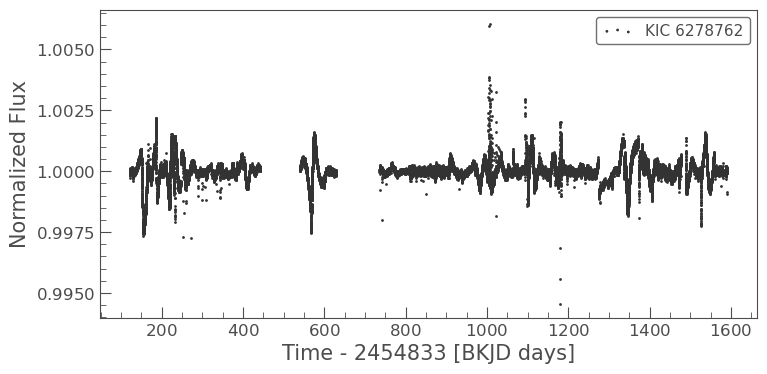

In [7]:
#lc = data.remove_outliers(lc, param_lists["pl_orbper"], param_lists["pl_tranmid"], param_lists["pl_trandur"],
 #                         transit_sigma_upper=5)
lc.scatter()

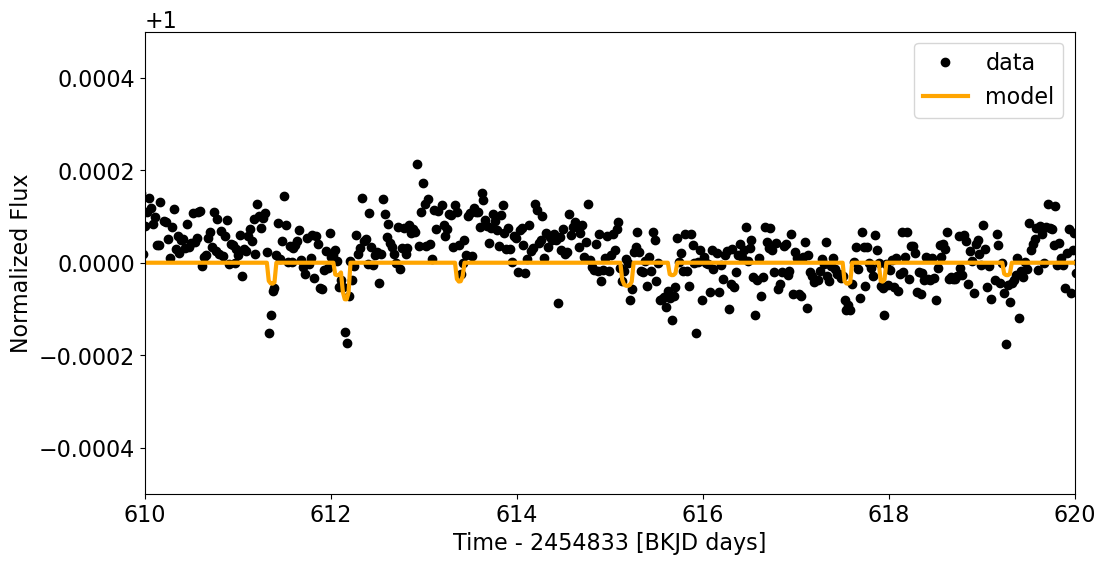

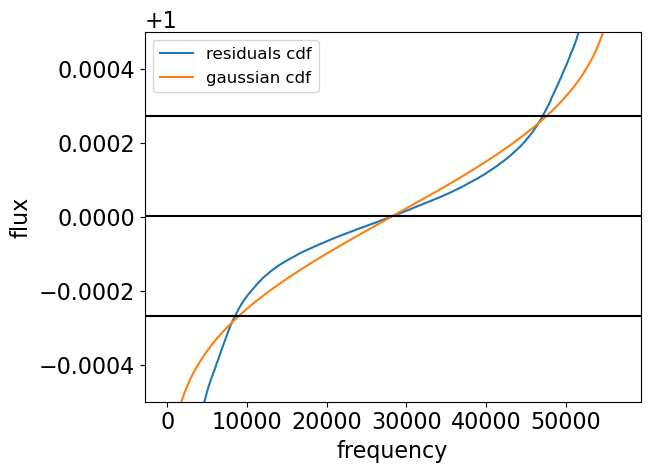

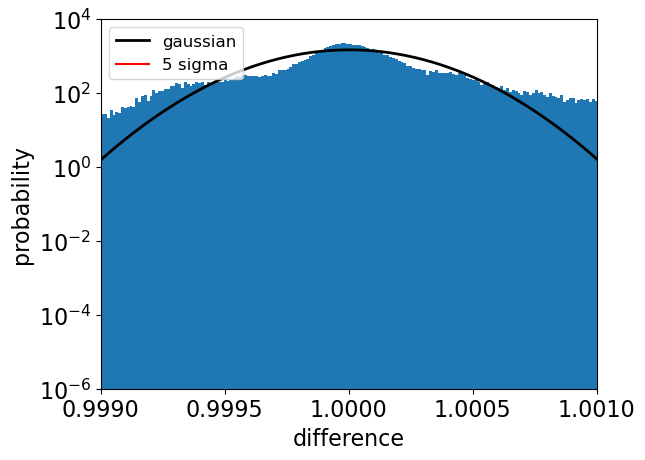

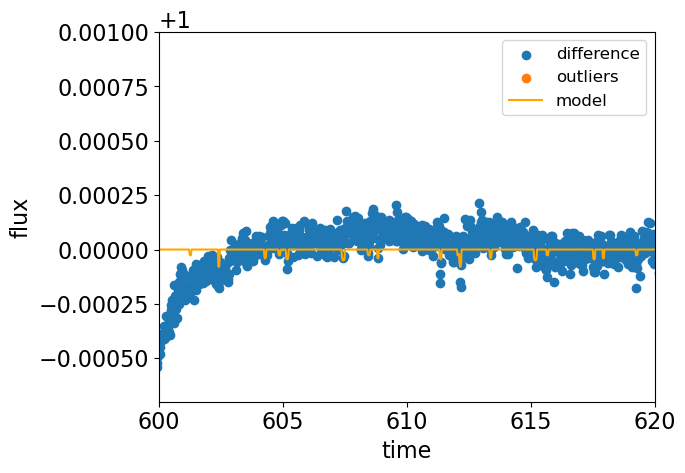

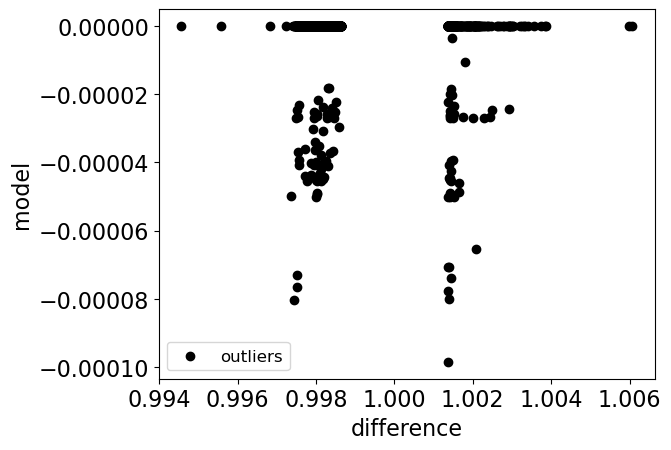

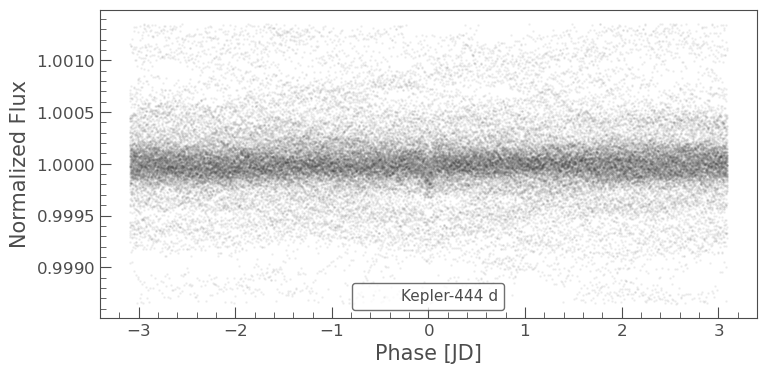

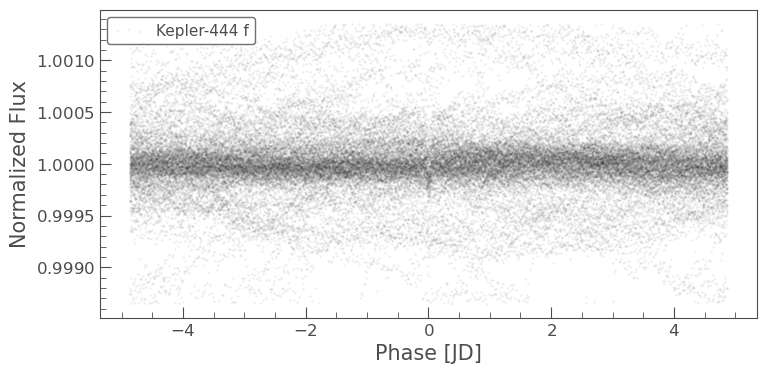

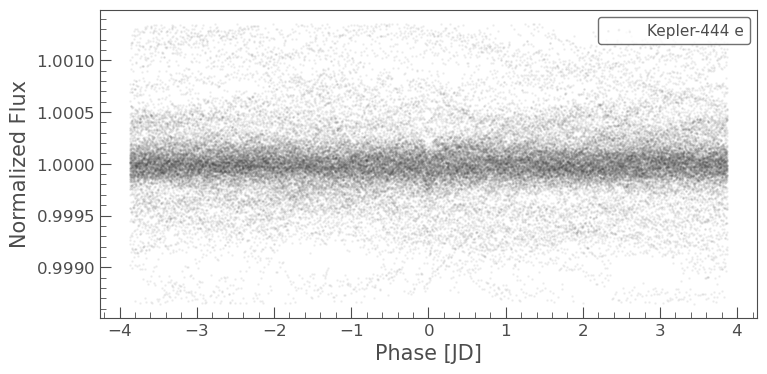

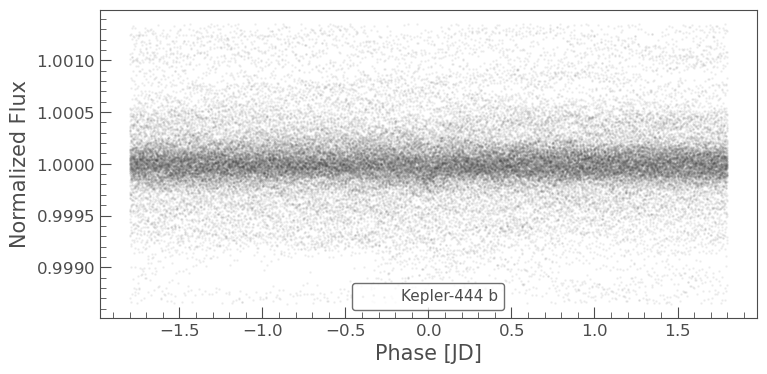

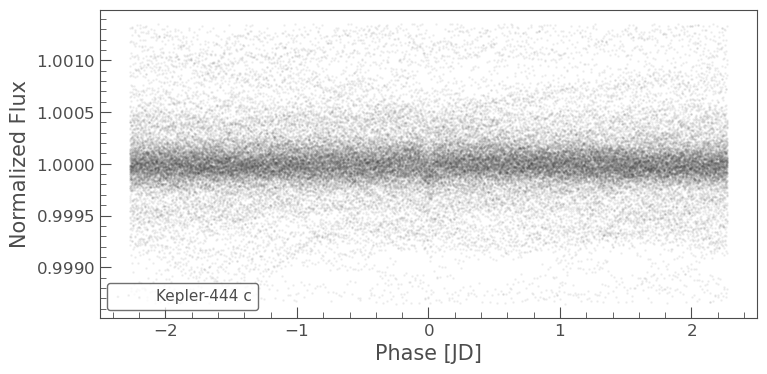

In [8]:
model, difference, std_calculated, mean_tweaked, light_curves = model_data_residuals(param_lists, lc)
lc_final, flags_5sigma = remove_outliers(5, lc, difference, std_calculated, mean_tweaked) # sigma = 5 
diagnostic_plots(lc, lc_final, model, difference, std_calculated, mean_tweaked)

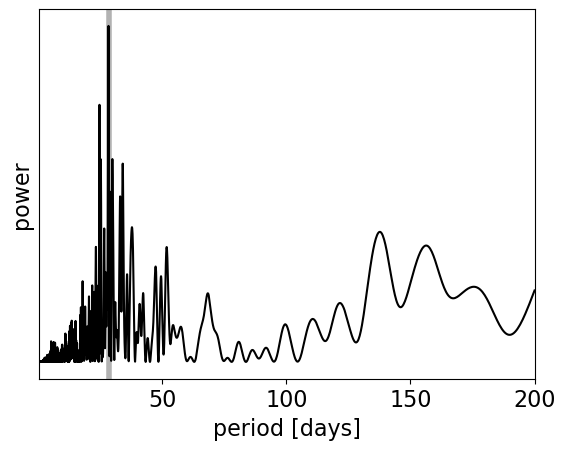

In [9]:
results = xo.estimators.lomb_scargle_estimator(
    lc_final.time.value, lc_final.flux.value, min_period=0.1, max_period=200.0, samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [10]:
peak['period']

28.297270875929215

In [11]:
param_lists

{'pl_name': ['Kepler-444 d',
  'Kepler-444 f',
  'Kepler-444 e',
  'Kepler-444 b',
  'Kepler-444 c'],
 'pl_letter': ['d', 'f', 'e', 'b', 'c'],
 'pl_orbper': [6.189392, 9.740486, 7.743493, 3.6001053, 4.5458841],
 'pl_orbincl': [88.16, 87.96, 89.13, 88.0, 88.2],
 'pl_orbeccen': [0.18, 0.29, 0.1, 0.16, 0.31],
 'pl_trandep': [0.00475, 0.00756, 0.00513, 0.00275, 0.0044],
 'pl_tranmid': [2454967.7869,
  2454967.8791,
  2454968.0927,
  2454966.2599,
  2454964.522],
 'pl_trandur': [2.2112, 1.6909, 2.7852, 2.0452, 1.7367],
 'pl_ratror': [0.00644, 0.00903, 0.00664, 0.00491, 0.00605],
 'pl_imppar': [0.53, 0.79, 0.29, 0.4, 0.42],
 'st_rad': [0.75, 0.75, 0.75, 0.75, 0.75],
 'st_mass': [0.76, 0.76, 0.76, 0.76, 0.76],
 'st_dens': [2.493, 2.493, 2.493, 2.493, 2.493],
 'gaia_id': ['Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808'],
 'pl_rade': [0.53, 0.741, 0.546, 0.403, 0.497],
 'berger

In [12]:
def optimise_model(lc, initial_guesses, texp=0.5 / 24, u_init=[0.3, 0.2]):
    """Optimise a transit model to fit some data

    Parameters
    ----------
    lc : :class:`~lightkurve.Lightcurve`
        The lightcurve data
    initial_guesses : `dict`
        Dictionary of initial guesses
    texp : `float`, optional
        Exposure time, by default 0.5/24
    u_init : `list`, optional
        Initial limb darkening guesses, by default [0.3, 0.2]

    Returns
    -------
    model
        PyMC3 model
    map_soln : `dict`
        Dictionary of optimised parameters
    """
    n_planets = len(initial_guesses["pl_orbper"])
    t0s_bkjd = Time(initial_guesses["pl_tranmid"], format="jd").bkjd

    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=1.0, sd=1.0) 

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s_bkjd, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(initial_guesses["pl_orbper"]), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening parameters
        # An uninformative prior for quadratic limb darkening parameters, flat distribution 
        # u1 (scalar) – The first limb darkening coefficient
        # u2 (scalar) – The second limb darkening coefficient
        limb_dark = xo.distributions.QuadLimbDark("u", testval=u_init)

        #*************************************#
        # do we want to do r or ror or r_star? 
        # I've seen examples use logror and logdur (so far we don't account for duration)
        #*************************************#
        
        # the radius of the transiting body, in units of solar radii 
        r = pm.Uniform(
            "r", lower=0.01, upper=0.1, shape=n_planets, testval=np.multiply(initial_guesses["pl_ratror"],initial_guesses['st_rad']))
        
        # the impact parameter, uniformly distributed between 0 and 1+ror, where ror is the radius ratio between planet and star
        #b = xo.distributions.ImpactParameter(
        #    "b", ror=r, shape=n_planets, testval=initial_guesses["pl_imppar"]) 
        
        b = pm.Uniform("b", lower=0, upper=1, shape=n_planets, testval=initial_guesses["pl_imppar"])

        # stellar density 
        initial_dens = initial_guesses["st_dens"][0] if initial_guesses["berger_dens"][0] == -1.0\
            else initial_guesses["berger_dens"][0]
        log_rho_star = pm.Normal("log_rho_star",
                                mu=np.log10(initial_dens), sd=1)
        rho_star = pm.Deterministic("rho_star", 10**(log_rho_star))

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, rho_star=rho_star)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(limb_dark[0], limb_dark[1]).get_light_curve(
            orbit=orbit, r=r, t=lc["time"].value, texp=texp)
        light_curve = tt.sum(light_curves, axis=-1) + mean 

        # Here we track the value of the model light curve for plotting purposes
        pm.Deterministic("light_curves", light_curves) # typo? 
        
        # Gaussian process 
        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_sigma_lc", mu=np.log(np.mean(lc['flux_err'])), sd=2)
        
        sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5))
        log_prot = pm.Normal("log_prot", mu=np.log(peak['period']), sd=0.02)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)
            
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f)
    
        gp = GaussianProcess(kernel, t=lc['time'].value, yerr=tt.exp(log_jitter))
        gp.marginal("transit_obs", observed=lc['flux'].value - light_curve)
        pm.Deterministic("gp_pred", gp.predict(lc['flux'].value - light_curve))
        freq = np.linspace(0.01,10, 5000)
        pm.Deterministic("psd", kernel.get_psd(freq))

        print(model.check_test_point())
        map_soln = pmx.optimize(start=model.test_point) # look into test_point, hopefully it starts with initial guesses

        return map_soln, model

In [13]:
map_soln, model = optimise_model(lc_final, param_lists)

AssertionError: Theano Assert failed!

In [ ]:
fig, ax = plt.subplots()
freq = np.linspace(0.01,10,5000)
plt.loglog(freq, map_soln['psd'], ":k", label="full model")
#plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day flux$^2$]")
plt.title("initial psd")
plt.text(.02, .01, 'Q={0}'.format(np.round(np.exp(map_soln['log_Q0']),decimals=2)), ha='left', va='bottom', transform=ax.transAxes)


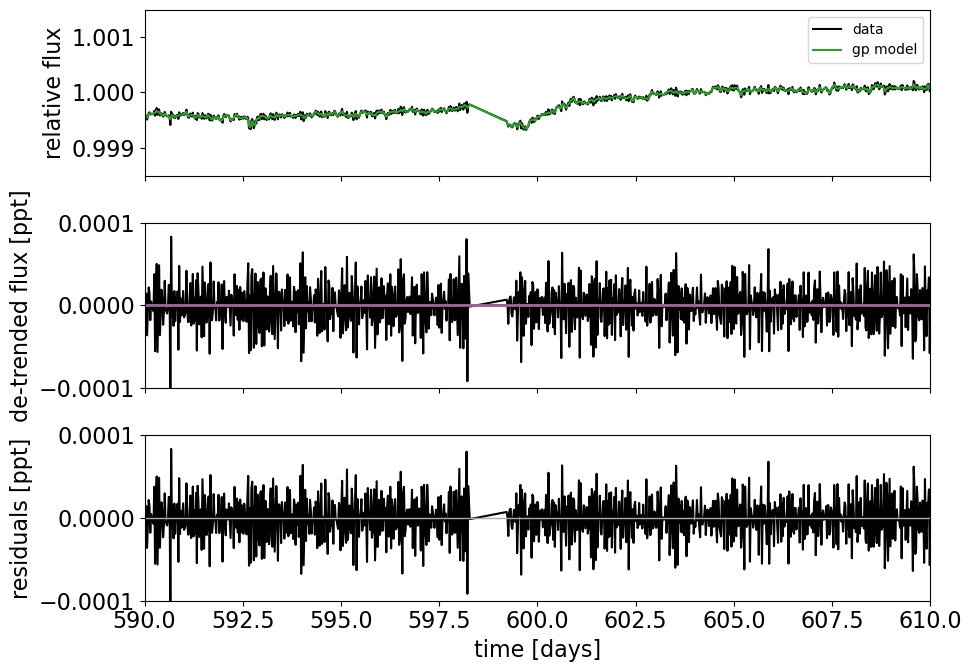

In [27]:
t = lc_final["time"].value
y = lc_final["flux"].value
gp_mod = map_soln["gp_pred"] + map_soln["mean"]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.plot(t, y, "k", label="data")
ax.plot(t, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=10)
ax.set_ylabel("relative flux")

ax = axes[1]
ax.plot(t, y - gp_mod, "k", label="de-trended data")
for i, l in enumerate("bcdef"):
    ax.plot(t, map_soln["light_curves"][:, i], label="planet {0}".format(l))
#ax.legend(fontsize=10, loc=3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_ylim(-0.0001,0.0001)

ax = axes[2]
mod = gp_mod + np.sum(map_soln["light_curves"], axis=-1)
ax.plot(t, y - mod, "k")
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("residuals [ppt]")
ax.set_ylim(-0.0001,0.0001)

plt.xlim(590,610)
plt.xlabel("time [days]")
plt.tight_layout()
plt.savefig('gp-kepler-109_zoom')

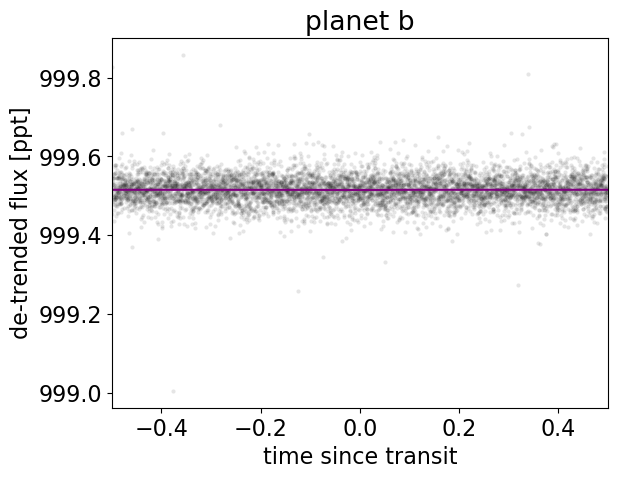

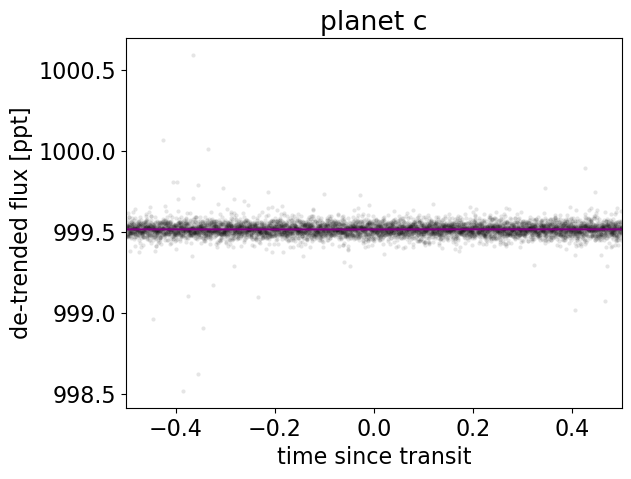

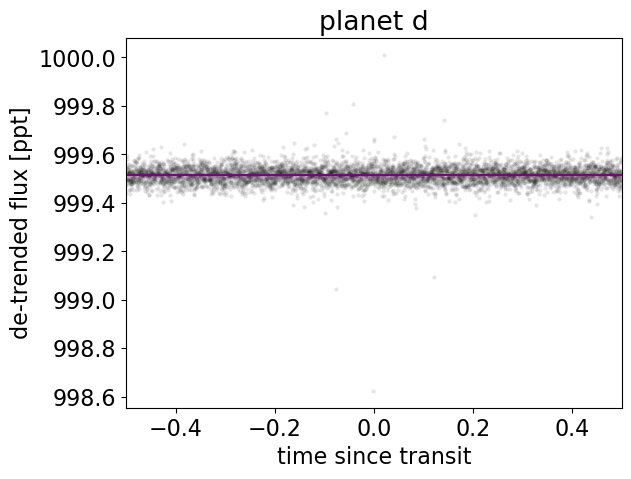

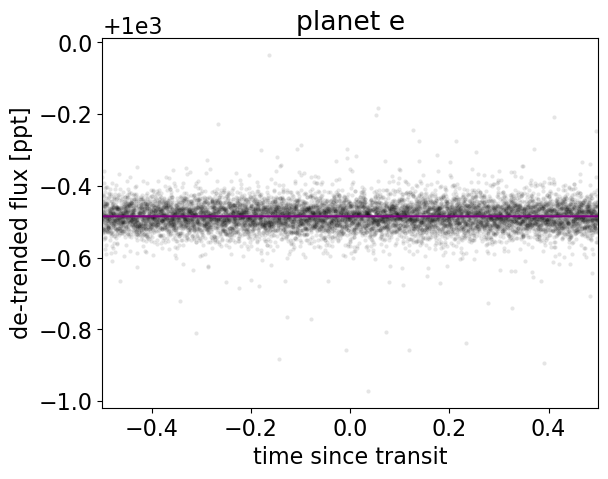

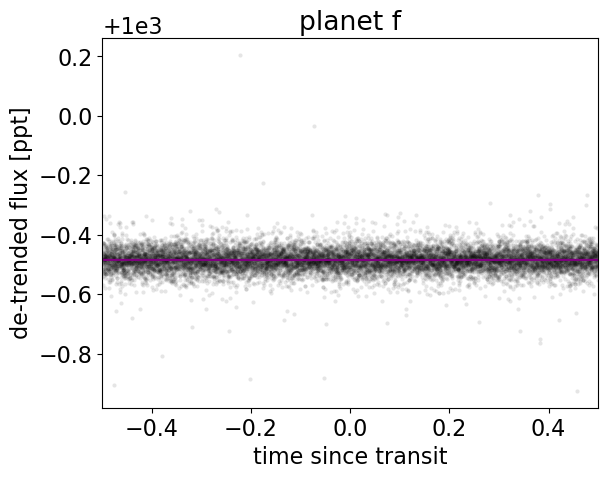

In [28]:
for n, letter in enumerate("bcdef"):
    plt.figure()
    
    x = lc_final.time.value
    y = lc_final["flux"].value
    period = map_soln["period"][n]
    t0 = np.median(map_soln["t0"][n])
    
    x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
    m = np.abs(x_fold) < 0.5
    plt.scatter(x_fold[m],1e3 * (y[m] - map_soln["gp_pred"][m]),c="k",marker=".",alpha=0.1,linewidths=0,)

    lc_mod = map_soln["light_curves"][:,n]
    lc_modx = np.sort(x_fold)
    lc_mody = lc_mod[np.argsort(x_fold)]
    plt.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

    # Overplot the phase binned light curve
    bins = np.linspace(-0.51, 0.51, 100)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - map_soln["gp_pred"])
    denom[num == 0] = 1.0
    #plt.scatter(0.5 * (bins[1:] + bins[:-1]),1e3 * num / denom,color="C1",zorder=2,linewidths=0,)

    plt.xlim(-0.5, 0.5)
    #plt.ylim(-3, 0.5)
    plt.ylabel("de-trended flux [ppt]")
    _ = plt.xlabel("time since transit")
    
    plt.title("planet {0}".format(letter))

In [203]:
map_soln

{'mean': array(1.00000027),
 't0': array([133.26138404, 131.52271738, 134.87978933, 135.09367754,
        134.78828113]),
 'logP': array([1.89843902, 1.46191425, 2.33861101, 2.40213245, 2.37271947]),
 'u_quadlimbdark__': array([-1.0986041 , -0.84729283]),
 'r_interval__': array([-3.58088557, -3.29530811, -2.78192122, -3.1727939 , -3.21278416]),
 'b_impact__': array([-0.41158069, -0.33056064,  1.29319798, -0.90236749,  0.10992098]),
 'log_rho_star': array(0.39681194),
 'log_sigma_lc': array(-11.12630507),
 'sigma_rot_log__': array(-0.09972321),
 'log_prot': array(4.32403189),
 'log_Q0': array(0.28070669),
 'log_dQ': array(0.01722063),
 'f_interval__': array(-0.08773505),
 'period': array([ 6.67546606,  4.31421011, 10.36682711, 11.04670786, 10.72652312]),
 'u': array([0.30000198, 0.19999956]),
 'r': array([0.00368254, 0.00453752, 0.00677259, 0.00498004, 0.00483006]),
 'b': array([0.40000078, 0.42000137, 0.79000236, 0.29000128, 0.53000024]),
 'rho_star': array(2.49351473),
 'light_curves'

In [188]:
param_lists

{'pl_name': ['Kepler-444 b',
  'Kepler-444 c',
  'Kepler-444 f',
  'Kepler-444 e',
  'Kepler-444 d'],
 'pl_letter': ['b', 'c', 'f', 'e', 'd'],
 'pl_orbper': [3.6001053, 4.5458841, 9.740486, 7.743493, 6.189392],
 'pl_orbincl': [88.0, 88.2, 87.96, 89.13, 88.16],
 'pl_orbeccen': [0.16, 0.31, 0.29, 0.1, 0.18],
 'pl_trandep': [0.00275, 0.0044, 0.00756, 0.00513, 0.00475],
 'pl_tranmid': [2454966.2599,
  2454964.522,
  2454967.8791,
  2454968.0927,
  2454967.7869],
 'pl_trandur': [2.0452, 1.7367, 1.6909, 2.7852, 2.2112],
 'pl_ratror': [0.00491, 0.00605, 0.00903, 0.00664, 0.00644],
 'pl_imppar': [0.4, 0.42, 0.79, 0.29, 0.53],
 'st_rad': [0.75, 0.75, 0.75, 0.75, 0.75],
 'st_dens': [2.493, 2.493, 2.493, 2.493, 2.493],
 'gaia_id': ['Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808',
  'Gaia DR2 2101486923385239808'],
 'pl_rade': [0.403, 0.497, 0.741, 0.546, 0.53],
 'berger_dens': [-1.0, -1.0, -1.0, -1.0, -1.0]}